In [310]:
import pandas as pd
import sys
import tensorflow as tf
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=100, type=int, help='batch size')
parser.add_argument('--train_steps', default=10000, type=int,
                    help='number of training steps')

_StoreAction(option_strings=['--train_steps'], dest='train_steps', nargs=None, const=None, default=10000, type=<class 'int'>, choices=None, help='number of training steps', metavar=None)

In [311]:
train_data = pd.read_csv("./train.csv")
validate = pd.read_csv('./test.csv')

In [313]:
train_data.fillna(0, inplace=True)

In [314]:
def remove_outliers(df=None,col_name=None):
    std =  df[col_name].std()
    m = df[col_name].mean()
    df['is_outlier'] = df[col_name].apply(lambda x : True if x < m - 2*std or x > m + 2*std else False)
    tmp_df = df[df['is_outlier']==False]
    return tmp_df.drop('is_outlier',axis=1)

In [315]:
for idx, value in enumerate(train_data.Age):
    if value ==0:
        if train_data['Sex'][idx] == 'male':
            train_data['Age'][idx] = 30
        else:
            train_data['Age'][idx] = 28
for idx, value in enumerate(validate_data.Age):
    if value ==0:
        if validate_data['Sex'][idx] == 'male':
            validate_data['Age'][idx] = 30
        else:
            validate_data['Age'][idx] = 28

/home/ubuntu/jupyter/remote_jupyter/lib/python3.4/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/jupyter/remote_jupyter/lib/python3.4/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [423]:
train_data.Fare.groupby(train_data.p_class).mean()

p_class
Second_class    20.662183
first_class     84.154687
third_class     13.675550
Name: Fare, dtype: float64

In [473]:
def estimate_fare(df):
    for idx,value in enumerate(df.p_class):
        if df['Fare'][idx]==0:
            if value == 'first_class':
                df['Fare'][idx] = 84.1
            elif value  == 'Second_class':
                df['Fare'][idx] = 20.66
            elif value  == 'third_class':
                df['Fare'][idx] = 13.67
    return df
train_data = estimate_fare(train_data)

In [474]:
def marriage_status(x):
    return str(str(x.split(',')[1]).split('.')[0]).strip().replace(" ",'_')

In [475]:
def normalize_series(series,max_x,min_x):
    return series.apply(lambda x: (x-min_x)/(max_x-min_x))

In [476]:
# find if user used multiple cabinet 
def used_multiple_cabins(s):
    s = str(s).split(' ')
    if len(s) >1:
        return 'Multiple_cabin'
    else:
        return 'One_Cabin'

In [477]:
#find cabin class
def cabin_class(s):
    s = str(s).split(' ')[0]
    if s == '0':
        return 'cabin_class_Unknown'
    else:
        return 'cabin_class_{}'.format(s[0])

In [994]:
def data_cleaning(df):
    #df = remove_outliers(df,'Fare')
    embarked_dummy = pd.get_dummies(df['Embarked'])
    sex_dummy = pd.get_dummies(df['Sex'])
    df['p_class']=df.Pclass.apply(lambda x : map_pclass(x))
    pclass_dummy = pd.get_dummies(df.p_class)
    df['n_fare'] = normalize_series(df.Fare,df.Fare.max(),df.Fare.min())
    #log fare value
    #df['n_fare'] = df.n_fare.apply(lambda x : np.log2(x))
    df['m_s'] = df.Name.apply(lambda x: marriage_status(x))
    m_s_dummy = pd.get_dummies(df.m_s)
    df['multiple_cabin'] = df.Cabin.apply(lambda x : used_multiple_cabins(x))
    multiple_cabin_dummy = pd.get_dummies(df.multiple_cabin)
    df['cabin_code'] = df.Cabin.apply(lambda x : cabin_class(x))
    cabin_code_dummy = pd.get_dummies(df.cabin_code)
    df  = pd.concat([df
                     ,embarked_dummy
                     ,sex_dummy
                     ,pclass_dummy
                     ,m_s_dummy
                     ,cabin_code_dummy
                     ,multiple_cabin_dummy
                    ], axis=1)
 
    df = df.drop([
                  'Name',
                  'Ticket',
                  'Cabin',
                  'Pclass',
                  'p_class',
                  'Sex',
                  'Embarked',
                  'Fare',
                  'm_s',
                  'multiple_cabin',
                  'cabin_code'
                 ],axis=1)
    return df

In [995]:
def map_pclass(x):
    if x == 1:
        return 'first_class'
    elif x == 2:
        return 'Second_class'
    elif x == 3:
        return 'third_class'
    else:
        return 'Unknown'

In [673]:
tmp_train_data = data_cleaning(train_data)

In [674]:
tmp_train_data = tmp_train_data.drop(0,axis=1)

In [671]:
tmp_train_data['Dona'] = 0

In [675]:
train, test = train_test_split(tmp_train_data, test_size=0.2)

In [996]:
tmp_validate_data = data_cleaning(validate_data)

In [676]:
test_x, test_y = test, test.pop('Survived')

In [677]:
train_x, train_y = train, train.pop('Survived')

In [678]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(1000).repeat().batch(batch_size)

In [679]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [680]:
my_feature_columns = []
for key in train_x.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [681]:
my_feature_columns

[_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='SibSp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='n_fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='C', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Q', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='S', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='female', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='male', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Second_class', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _Nume

In [1213]:
HIDDEN_LAYER=[200,100,80,50,50]
DROPOUT = 0.01

## current best performing parameters [200,100,80,50,50] learning rate = 0.00006, no dropout, batch_size = 800, steps = 8000

In [1214]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=HIDDEN_LAYER,
    optimizer=tf.train.AdagradOptimizer(
      learning_rate=0.00006
    ),
#     optimizer=tf.train.GradientDescentOptimizer(
#       learning_rate=0.000001
#     ),
    # The model must choose between 3 classes.
    n_classes=2
    ,dropout=DROPOUT
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_num_worker_replicas': 1, '_service': None, '_model_dir': '/tmp/tmp9ji94pr9', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_task_type': 'worker', '_tf_random_seed': None, '_master': '', '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa11faba048>, '_is_chief': True}


In [1215]:
classifier.train(
    input_fn=lambda:train_input_fn(train_x,train_y,batch_size=800), steps=8000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp9ji94pr9/model.ckpt.
INFO:tensorflow:loss = 580.7579, step = 1
INFO:tensorflow:global_step/sec: 41.4359
INFO:tensorflow:loss = 560.78174, step = 101 (2.414 sec)
INFO:tensorflow:global_step/sec: 43.3249
INFO:tensorflow:loss = 552.978, step = 201 (2.308 sec)
INFO:tensorflow:global_step/sec: 43.1037
INFO:tensorflow:loss = 548.0115, step = 301 (2.320 sec)
INFO:tensorflow:global_step/sec: 41.6074
INFO:tensorflow:loss = 543.95276, step = 401 (2.403 sec)
INFO:tensorflow:global_step/sec: 43.1861
INFO:tensorflow:loss = 539.61365, step = 501 (2.316 sec)
INFO:tensorflow:global_step/sec: 43.164
INFO:tensorflow:loss = 536.509, step = 601 (2.317 sec)
INFO:tensorflow:global_step/sec: 43.5572
INFO:tensorflow:loss = 533.37476, step = 701 (2.296 sec)
INFO:tensorflow:global_step/sec: 43.3954
INFO:tensorflow:loss = 530.3895, step = 801 (2.304 sec)
INFO:tensorflow:global_step/sec: 43.2732
INFO:tensorflow:loss 

In [1216]:
eval_result = classifier.evaluate(
    input_fn=lambda:eval_input_fn(test_x, test_y, 1000))

print('\nTest set accuracy: {}\n'.format(eval_result['accuracy']))

grid_search = grid_search.append({'hidden_layer':str(HIDDEN_LAYER).replace(',','_').replace(' ','').replace(']','').replace('[','')
                    ,'dropout':DROPOUT
                    ,'accuracy': eval_result['accuracy']},ignore_index=True)

INFO:tensorflow:Starting evaluation at 2018-04-17-03:56:03
INFO:tensorflow:Restoring parameters from /tmp/tmp9ji94pr9/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-04-17-03:56:04
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.83040935, accuracy_baseline = 0.6374269, auc = 0.8635691, auc_precision_recall = 0.8369951, average_loss = 0.45441094, global_step = 8000, label/mean = 0.3625731, loss = 77.70427, prediction/mean = 0.3961867

Test set accuracy: 0.8304093480110168



In [1217]:
predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(final_validate_data_v,None,batch_size=1000))
result_df = pd.DataFrame(columns=['Survived'])
for predic in predictions:
    row = {'Survived': predic['class_ids'][0]}
    result_df = result_df.append(row,ignore_index=True)
df = pd.concat([final_validate_data.PassengerId.reset_index(drop=True),result_df],axis=1)

INFO:tensorflow:Restoring parameters from /tmp/tmp9ji94pr9/model.ckpt-8000


In [1218]:
df.shape

(418, 2)

In [1219]:
Last_prediction = pd.read_csv("./predicted_age.csv")

In [1220]:
df.to_csv('./predicted_age.csv',index=False)

In [1221]:
(df.Survived == Last_prediction.Survived).describe()

count      418
unique       2
top       True
freq       406
Name: Survived, dtype: object

In [ ]:
wrong_prediction = df.query("Survived != p_Survived")

In [773]:
right_prediction = df.query("Survived == p_Survived")

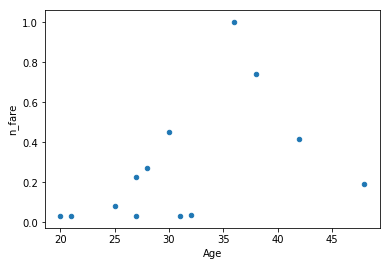

In [796]:
p = wrong_prediction.query('Survived==1&S==1&male==1').plot.scatter('Age','n_fare')

In [816]:
wrong_prediction.male.groupby(wrong_prediction.male).count()/28

male
0    0.357143
1    0.642857
Name: male, dtype: float64

In [818]:
wrong_prediction.Age.groupby(wrong_prediction.Age).count()/28

Age
4.0     0.035714
5.0     0.035714
18.0    0.071429
20.0    0.035714
21.0    0.035714
22.0    0.071429
24.0    0.035714
25.0    0.035714
26.0    0.035714
27.0    0.071429
28.0    0.035714
30.0    0.107143
31.0    0.035714
32.0    0.071429
36.0    0.035714
38.0    0.035714
40.0    0.035714
42.0    0.035714
45.0    0.071429
48.0    0.035714
50.0    0.035714
Name: Age, dtype: float64

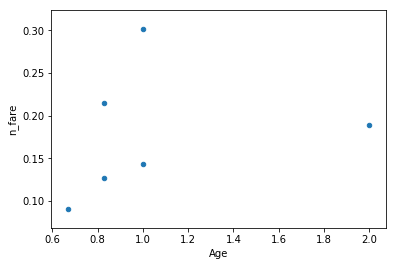

In [797]:
right_prediction.query('Survived==1&S==1&male==1').plot.scatter('Age','n_fare')

In [973]:
predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(final_validate_data_v,None,batch_size=1000))
result_df = pd.DataFrame(columns=['Survived'])
for predic in predictions:
    row = {'Survived': predic['class_ids'][0]}
    result_df = result_df.append(row,ignore_index=True)

INFO:tensorflow:Restoring parameters from /tmp/tmpbaj4o6_q/model.ckpt-4000


KeyError: 'class_ids'

In [703]:
df = pd.concat([validate,result_df], axis=1)

In [221]:
df.to_csv('./{}_{}_restul.csv'.format(str(HIDDEN_LAYER).replace(',','_').replace(' ','').replace(']','').replace('[',''),
                                      int(DROPOUT*10),index=False))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0,)
clf.fit(train_x,train_y)
scores = cross_val_score(clf, test_x, test_y)
scores.mean()                             

In [475]:
train_x.columns

Index(['Age', 'SibSp', 'Parch', 'n_fare', 'C', 'Q', 'S', 'female', 'male',
       'Second_class', 'first_class', 'third_class', 'Capt', 'Col', 'Don',
       'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme',
       'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the_Countess', 'Dona'],
      dtype='object')

In [476]:
validate_data.columns

Index(['Age', 'SibSp', 'Parch', 'n_fare', 'C', 'Q', 'S', 'female', 'male',
       'Second_class', 'first_class', 'third_class', 'Col', 'Dona', 'Dr',
       'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Rev', 'Capt', 'Don', 'Jonkheer',
       'Lady', 'Major', 'Mlle', 'Mme', 'Sir', 'the_Countess'],
      dtype='object')

In [477]:
result_df = pd.DataFrame(columns=['Survived'])
predictions = clf.predict(validate_data)
for predic in predictions:
    row = {'Survived': predic}
    result_df = result_df.append(row,ignore_index=True)
df = pd.concat([validate.PassengerId,result_df], axis=1)

In [478]:
df.to_csv('rf.csv',index=False)

In [ ]:
## predict age based on fare, SibSp, Parch, Marriage_status,sex

In [852]:
age_predict= tmp_train_data.drop(['Survived'],axis=1)

In [853]:
age_predict_train,age_predict_test = train_test_split(age_predict, test_size=0.2)

In [854]:
age_predict_train_x,age_predict_train_y = age_predict_train,age_predict_train.pop('Age')

In [861]:
age_predict_train_x.columns

Index(['SibSp', 'Parch', 'n_fare', 'C', 'Q', 'S', 'female', 'male',
       'Second_class', 'first_class', 'third_class', 'Capt', 'Col', 'Don',
       'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme',
       'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the_Countess'],
      dtype='object')

In [855]:
age_predict_test_x,age_predict_test_y = age_predict_test,age_predict_test.pop('Age')

In [998]:
validate_data_to_predict = tmp_validate_data[pd.isnull(tmp_validate_data.Age)==True]

In [999]:
validate_data_to_predict_x = validate_data_to_predict.drop(['Age','PassengerId'],axis=1)

In [1000]:
my_feature_columns = []
for key in age_predict_train_x.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [1001]:
classifier = tf.estimator.DNNRegressor(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=HIDDEN_LAYER,
    optimizer=tf.train.AdagradOptimizer(
      learning_rate=0.001
    ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_num_worker_replicas': 1, '_service': None, '_model_dir': '/tmp/tmp7ueuoux8', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_task_type': 'worker', '_tf_random_seed': None, '_master': '', '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa1b0541a58>, '_is_chief': True}


In [1002]:
classifier.train(
    input_fn=lambda:train_input_fn(age_predict_train_x,age_predict_train_y,batch_size=800), steps=4000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp7ueuoux8/model.ckpt.
INFO:tensorflow:loss = 826930.75, step = 1
INFO:tensorflow:global_step/sec: 25.4111
INFO:tensorflow:loss = 89356.984, step = 101 (3.936 sec)
INFO:tensorflow:global_step/sec: 25.9275
INFO:tensorflow:loss = 79033.69, step = 201 (3.857 sec)
INFO:tensorflow:global_step/sec: 25.8951
INFO:tensorflow:loss = 72394.74, step = 301 (3.862 sec)
INFO:tensorflow:global_step/sec: 25.1527
INFO:tensorflow:loss = 72348.69, step = 401 (3.976 sec)
INFO:tensorflow:global_step/sec: 26.147
INFO:tensorflow:loss = 72235.984, step = 501 (3.825 sec)
INFO:tensorflow:global_step/sec: 25.8845
INFO:tensorflow:loss = 71372.26, step = 601 (3.863 sec)
INFO:tensorflow:global_step/sec: 25.6791
INFO:tensorflow:loss = 67064.62, step = 701 (3.894 sec)
INFO:tensorflow:global_step/sec: 26.0563
INFO:tensorflow:loss = 70162.38, step = 801 (3.838 sec)
INFO:tensorflow:global_step/sec: 26.1422
INFO:tensorflow:loss

In [1003]:
eval_result = classifier.evaluate(
    input_fn=lambda:eval_input_fn(age_predict_test_x, age_predict_test_y, 1000))

print(eval_result)

INFO:tensorflow:Starting evaluation at 2018-04-13-06:56:31
INFO:tensorflow:Restoring parameters from /tmp/tmp7ueuoux8/model.ckpt-4000
INFO:tensorflow:Finished evaluation at 2018-04-13-06:56:31
INFO:tensorflow:Saving dict for global step 4000: average_loss = 144.92404, global_step = 4000, loss = 24782.012
{'average_loss': 144.92404, 'loss': 24782.012, 'global_step': 4000}


In [930]:
age_predict_test_x.columns

Index(['SibSp', 'Parch', 'n_fare', 'C', 'Q', 'S', 'female', 'male',
       'Second_class', 'first_class', 'third_class', 'Capt', 'Col', 'Don',
       'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme',
       'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the_Countess'],
      dtype='object')

In [1004]:
validate_data_to_predict_x['Capt'] = 0
validate_data_to_predict_x['Don'] = 0
validate_data_to_predict_x['Jonkheer'] = 0
validate_data_to_predict_x['Lady'] = 0
validate_data_to_predict_x['Major'] = 0
validate_data_to_predict_x['Mlle'] = 0
validate_data_to_predict_x['Mme'] = 0
validate_data_to_predict_x['Sir'] = 0
validate_data_to_predict_x['Mme'] = 0
validate_data_to_predict_x['the_Countess'] = 0
validate_data_to_predict_x['Mme'] = 0

In [1005]:
validate_data_to_predict_x= validate_data_to_predict_x.reset_index(drop=True)

predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(validate_data_to_predict_x,None,batch_size=1000))
result_df = pd.DataFrame(columns=['Age'])
for predic in predictions:
    row = {'Age': predic['predictions'][0]}
    result_df = result_df.append(row,ignore_index=True)
df = pd.concat([tmp_validate_data.PassengerId[pd.isnull(tmp_validate_data.Age)==True].reset_index(drop=True),validate_data_to_predict_x,result_df],axis=1)

INFO:tensorflow:Restoring parameters from /tmp/tmp7ueuoux8/model.ckpt-4000


In [1006]:
final_validate_data = pd.concat([df,tmp_validate_data[pd.isnull(tmp_validate_data.Age)==False]],axis=0)

In [1007]:
final_validate_data.fillna(0,inplace=True)

In [1008]:
final_validate_data_v = final_validate_data.drop('PassengerId',axis=1)

In [1009]:
final_validate_data_v.shape

(418, 41)